In [1]:
import os
import re
import shutil
from pathlib import Path
import random
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
from collections import OrderedDict
from tqdm import tqdm
tqdm.pandas()
import seaborn as sns
from PIL import Image
import cv2 as cv
from datetime import date

from skimage import morphology

import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import ExplicitVRLittleEndian
import pydicom._storage_sopclass_uids

# https://www.lfd.uci.edu/~gohlke/pythonlibs/#vtk
import vtk

# https://github.com/tforgione/model-converter-python
import d3.model.tools as mt
from d3.model.basemodel import Vector

In [2]:
work_dir = Path.cwd()
main_dir = work_dir.parents[0]

search_csv_path = main_dir / 'search_output_update.csv'
geo_csv_path = main_dir / 'feature_output.csv'
mech_csv_path = main_dir / 'mechanic_output.csv'
img_dir = work_dir.parents[1] / 'SWCLab' / 'img_src_all'
dcm_dir = work_dir.parents[1] / 'SWCLab' / 'dcm_src'

output_dir = work_dir / 'plot'
os.makedirs(output_dir, exist_ok=True)

In [3]:
def add_filepath(df, img_dir, dcm_dir):
    df[['ID', 'Section', 'Offset_X', 'Offset_Y']] = df[['ID', 'Section', 'Offset_X', 'Offset_Y']].astype(int).astype(str)

    def generate_image_path(row):
        return os.path.join(img_dir, f"{row['Class'][0]}_{row['Patient Name']}_ID[{row['ID'].zfill(3)}]_s[{row['Section']}]_x[{row['Offset_X']}]_y[{row['Offset_Y']}].png")

    def generate_dcm_dir(row):
        return os.path.join(dcm_dir, row['Class'], row['Order'], row['Family'], row['Genus-Species'], row['Part'])

    df["Image Path"] = df.progress_apply(generate_image_path, axis=1)
    df["DCM dir"] = df.progress_apply(generate_dcm_dir, axis=1)

    return df

class DataFrame:
    def __init__(self, search_path, geo_path, mech_path=None):
        search_cols = ['Order', 'Family', 'Genus-Species', 'Part', 'Patient Name']
        common_cols = ['Class', 'Patient Name', 'ID', 'Section', 'Offset_X', 'Offset_Y']

        self.search_df = self._read_csv(search_path, search_cols)
        self.geo_df = self._read_csv(geo_path)

        self.df = pd.merge(self.search_df, self.geo_df, on='Patient Name', how='outer')
        if mech_path:
            self.mech_df = self._read_csv(mech_path)
            self.df = pd.merge(self.df, self.mech_df, on=['Class', 'Patient Name', 'ID', 'Section', 'Offset_X', 'Offset_Y'], how='outer')
        self.df.drop_duplicates(subset=set(common_cols), inplace=True)
        self.df = self.df.dropna().reset_index(drop=True)    
        # self.df[['Genus-Species', 'Part']] = self.df[['Genus-Species', 'Part']].applymap(self._replace_text) 

    def _read_csv(self, path, cols=None):
        if cols is None:
            df = pd.read_csv(path, sep=',').dropna().reset_index(drop=True)
        else:
            df = pd.read_csv(path, sep=',', usecols=cols).dropna().reset_index(drop=True)
        return df 

    def _replace_text(self, text):
        text = re.sub(r'_', ' ', text)
        text = re.sub(r'-', '-\n', text)
        return text                       

    def get_dataframe(self):
        return self.df

def print_dataframe(df, sample=False, n_samples=5):
    df_copy = df.copy()
    cols_to_check = ["Image Path", "DCM dir",  "File Path in ZIP"]
    for col in cols_to_check:
        if col in df.columns:
            df_copy[col] = df_copy[col].apply(lambda x: os.path.relpath(x))       
    seed = random.randint(1, 100)
    if sample:
        print(df.sample(min(n_samples, len(df)), random_state=seed).to_markdown())
    else:
        print(df_copy.to_markdown())
    print('-'*100)

def summarize_dataframe(df, col="Patient Name"):
    class_distribution = df[col].value_counts()
    ratio = (class_distribution / class_distribution.sum()).mul(100).round(2)
    ratio = list(map(lambda x: f"{x:.2f}%", ratio))

    df_summary = pd.DataFrame({"Count": class_distribution, "Ratio": ratio})
    df_summary.sort_index(inplace=True) 
    if isinstance(df_summary.index[0], tuple):
        df_summary.index = df_summary.index.map(lambda x: " & ".join(x))

    df_summary.loc["Total"] = {"Count": df_summary["Count"].sum(), "Ratio": "100%"}    
    return df_summary
     
df = DataFrame(search_csv_path, geo_csv_path, mech_csv_path).get_dataframe() 
df = add_filepath(df, img_dir, dcm_dir) 
print_dataframe(df, sample=True)

species_summery = summarize_dataframe(df, col="Genus-Species")
print_dataframe(species_summery)
part_summery = summarize_dataframe(df, col="Part")
print_dataframe(part_summery)

100%|██████████| 4782/4782 [00:00<00:00, 90181.43it/s]


|      | Order          | Family         | Genus-Species                          | Part       | Patient Name        | Class   |   ID |   Section |   Offset_X |   Offset_Y |   Porosity |   Avg Trabeculae Angle |   Std Trabeculae Angle |   Avg Trabeculae Thickness |   Std Trabeculae Thickness |   Avg Trabeculae Curl |   Std Trabeculae Curl |   Avg Area |   Std Area |   Avg Convex Area |   Std Convex Area |   Avg Ratio of Area to Perimeter |   Std Ratio of Area to Perimeter |   Avg Compactness |   Std Compactness |   Avg Circularity |   Std Circularity |   Avg Width to Length |   Std Width to Length |   Avg Centroid_X |   Std Centroid_X |   Avg Centroid_Y |   Std Centroid_Y |   stress_b (MPa) |   strain_b (%) |   stress_u (MPa) |   strain_u (%) |   Young's Modulus (GPa) |   Toughness (MPa) |   All Broken Bond_b (%) |   All Broken Bond_u (%) |   All Broken Bond_f (%) |   Stiff Broken Bond_f (%) |   Soft Broken Bond_f (%) |   Inter Broken Bond_f (%) | Image Path                            

In [4]:
def read_png(image_path):
    with Image.open(image_path).convert('L') as img:
        array = np.array(img)/255
    return array

def image_x_shift(img, shift_ratio=0.1,crop_ratio=1):
    h, w = img.shape
    new_h, new_w = int(h*crop_ratio), int(w*crop_ratio)
    mid_x, mid_y = w//2, h//2
    shift = int(img.shape[1] * shift_ratio)
    if shift == 0:
        return img
    img_shifted = np.zeros_like(img)
    img_shifted[:, :shift] = img[:, -shift:]
    img_shifted[:, shift:] = img[:, :-shift]
    img_shifted = img_shifted[mid_y-new_h//2:mid_y+new_h//2, mid_x-new_w//2:mid_x+new_w//2]
    return img_shifted
    
# def image_y_shift(img, shift_ratio=0.1,crop_ratio=1):
#     h, w = img.shape
#     new_h, new_w = int(h*crop_ratio), int(w*crop_ratio)
#     mid_x, mid_y = w//2, h//2
#     shift = int(img.shape[0] * shift_ratio)
#     if shift == 0:
#         return img
#     img_shifted = np.zeros_like(img)
#     img_shifted[:shift, :] = img[-shift:, :]
#     img_shifted[shift:, :] = img[:-shift, :]
#     img_shifted = img_shifted[mid_y-new_h//2:mid_y+new_h//2, mid_x-new_w//2:mid_x+new_w//2]
#     return img_shifted

def rotate_image(img, angle, crop_ratio=1, mirror=False):
    h, w = img.shape
    new_h, new_w = int(h*crop_ratio), int(w*crop_ratio)
    img_rotated = Image.fromarray(img).rotate(angle)
    mid_x, mid_y = img_rotated.size[0]//2, img_rotated.size[1]//2
    img_rotated = img_rotated.crop((mid_x-new_w//2, mid_y-new_h//2, mid_x+new_w//2, mid_y+new_h//2))
    img_rotated = np.array(img_rotated)

    if mirror:
        img_rotated = np.concatenate((img_rotated, img_rotated[:, ::-1]), axis=1)
        img_rotated = np.concatenate((img_rotated, img_rotated[::-1, :]), axis=0)
        
    img_rotated = morphology.remove_small_objects(img_rotated > 0, min_size=10)
    img_rotated = img_rotated.astype(float)
    return img_rotated
        
def add_margin(img, margin_range=2):
    if margin_range == 0:
        return img
    else:
        margin_img = np.zeros((img.shape[0]+margin_range*2, img.shape[1]+margin_range*2))
        margin_img[margin_range:-margin_range, margin_range:-margin_range] = img
        return margin_img

In [14]:
class BezierCurve:
    def __init__(self, n=4, control_points=None, bezier_curve=None,id=None):
        self.n = n
        self.control_points = control_points
        self.bezier_curve = bezier_curve
        self.id = id

    def generate_control_points(self):
        # Generate random control points for y
        y_values = [0]  # Start point
        for _ in range(self.n - 1):
            y_values.append(np.random.randint(0, 100))
        y_values.sort()
        y_values = [round(y / 100, 3) for y in y_values]  # Normalize y values

        # Control points
        control_points = [(0, 0)]  # Fixed start point
        for i in range(1, self.n - 1):
            x = np.random.uniform(-1, 1)
            control_points.append((round(x, 3), y_values[i]))
        control_points.append((0, 1))  # Fixed end point

        self.control_points = control_points

    def parameterize_curve(self):
        if self.control_points is None:
            self.generate_control_points()

        # Parameterize the bezier curve
        t = np.linspace(0, 1, 100)
        bezier_curve = np.array([(1 - t) ** 3 * self.control_points[0][0] + 3 * t * (1 - t) ** 2 * self.control_points[1][0]
                                 + 3 * t ** 2 * (1 - t) * self.control_points[2][0] + t ** 3 * self.control_points[3][0],
                                 (1 - t) ** 3 * self.control_points[0][1] + 3 * t * (1 - t) ** 2 * self.control_points[1][1]
                                 + 3 * t ** 2 * (1 - t) * self.control_points[2][1] + t ** 3 * self.control_points[3][1]])

        self.bezier_curve = bezier_curve

    def plot(self):
        if self.bezier_curve is None:
            self.parameterize_curve()

        # Plot the bezier curve
        if self.id:
            plt.plot(self.bezier_curve[0], self.bezier_curve[1], label=f'Bezier Curve {self.id}')
            plt.scatter(*zip(*self.control_points), label=f'Control Points {self.id}')
        else:
            plt.plot(self.bezier_curve[0], self.bezier_curve[1], label='Bezier Curve')
            plt.scatter(*zip(*self.control_points), label='Control Points')
        plt.xlim(-1, 1)
        plt.ylim(0, 1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Random Bezier Curve')
        plt.legend()
        plt.grid(True)
        plt.savefig(output_dir / 'bezier_curve.png')

    @property
    def pts(self):
        if self.control_points is None:
            self.generate_control_points()

        print("Control Points (excluding start and end points):")
        for point in self.control_points[1:-1]:
            print(f"({point[0]}, {point[1]})")

    def slice(self, n):
        y_values = np.linspace(0, 1, n+2)
        x_values = []
        for y in y_values:
            for t in np.linspace(0, 1, 100):
                y_curve = (1 - t) ** 3 * self.control_points[0][1] + 3 * t * (1 - t) ** 2 * self.control_points[1][1] \
                          + 3 * t ** 2 * (1 - t) * self.control_points[2][1] + t ** 3 * self.control_points[3][1]
                if abs(y_curve - y) < 0.01:
                    x_values.append((1 - t) ** 3 * self.control_points[0][0] + 3 * t * (1 - t) ** 2 * self.control_points[1][0] \
                                    + 3 * t ** 2 * (1 - t) * self.control_points[2][0] + t ** 3 * self.control_points[3][0])
                    break
        # print(f"Slice points for {n} slices:")
        # for x in x_values:
        #     print(round(x, 3))
        
        return x_values

    def slcshow(self, n):
        x_values = self.slice(n)
        for x in x_values:
            plt.axvline(x=x, color='gray', linestyle='--')

        self.plot()
        plt.show()
    
    def output_csv(self):
        if self.control_points is None:
            self.generate_control_points()
        if self.bezier_curve is None:
            self.parameterize_curve()
        
        # Output control points to csv,which generate an ID to thecurve and can be appended to the original csv
        if not os.path.exists(output_dir / 'bezier_curve.csv'):
            num = 1
            data = {'ID': [f'{num}'], 'X': [self.control_points[0][0]], 'Y': [self.control_points[0][1]]}
            for i in range(1, self.n):
                data['ID'].append(f'{num}')
                data['X'].append(self.control_points[i][0])
                data['Y'].append(self.control_points[i][1])
            df = pd.DataFrame(data)
            df.to_csv(output_dir / 'bezier_curve.csv', index=False)
        else:
            num = pd.read_csv(output_dir / 'bezier_curve.csv')['ID'].max() + 1
            data = {'ID': [f'{num}'], 'X': [self.control_points[0][0]], 'Y': [self.control_points[0][1]]}
            for i in range(1, self.n):
                data['ID'].append(f'{num}')
                data['X'].append(self.control_points[i][0])
                data['Y'].append(self.control_points[i][1])
            df_read = pd.read_csv(output_dir / 'bezier_curve.csv')
            df = pd.DataFrame(data)
            df = pd.concat([df_read, df], ignore_index=True)
            df.to_csv(output_dir / 'bezier_curve.csv', index=False)

    def read_csv(self, path=output_dir / 'bezier_curve.csv'):
        return pd.read_csv(path)
        

# Test the class

# k = BezierCurve()
# k.generate_control_points()
# k.plot()
# k.pts
# k.slcshow(4)
# k.output_csv()


In [35]:
# Generate 100 random Bezier curves and output to csv
for i in range(100):
    k = BezierCurve()
    k.generate_control_points()
    k.output_csv()

Random Bezier Curve No.1 Control Points (excluding start and end points):
(-0.419, 0.25)
(0.598, 0.29)


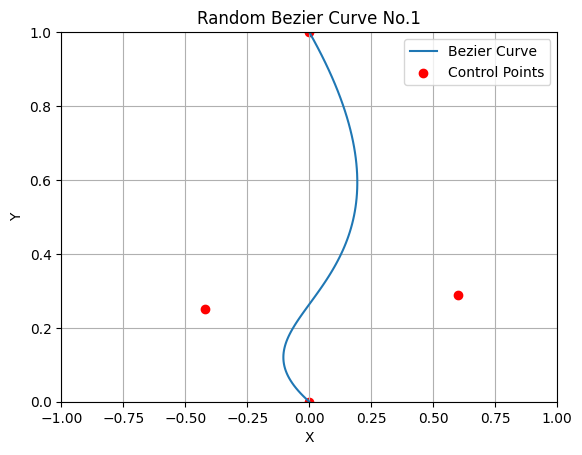

Random Bezier Curve No.1 Control Points (excluding start and end points):
(-0.419, 0.25)
(0.598, 0.29)
Random Bezier Curve No.23 Control Points (excluding start and end points):
(0.979, 0.23)
(-0.319, 0.58)
Random Bezier Curve No.24 Control Points (excluding start and end points):
(-0.361, 0.1)
(-0.48, 0.35)
Random Bezier Curve No.95 Control Points (excluding start and end points):
(-0.982, 0.28)
(0.935, 0.3)
Random Bezier Curve No.175 Control Points (excluding start and end points):
(-0.961, 0.03)
(0.95, 0.29)


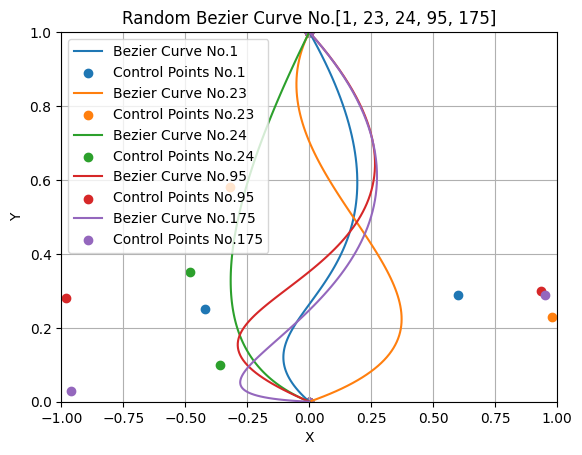

Random Bezier Curve No.30 Control Points (excluding start and end points):
(-0.807, 0.36)
(0.471, 0.79)
Random Bezier Curve No.33 Control Points (excluding start and end points):
(0.869, 0.13)
(-0.849, 0.15)
Random Bezier Curve No.64 Control Points (excluding start and end points):
(-0.793, 0.03)
(-0.821, 0.31)
Random Bezier Curve No.141 Control Points (excluding start and end points):
(-0.655, 0.46)
(0.288, 0.86)
Random Bezier Curve No.185 Control Points (excluding start and end points):
(0.001, 0.39)
(-0.792, 0.71)


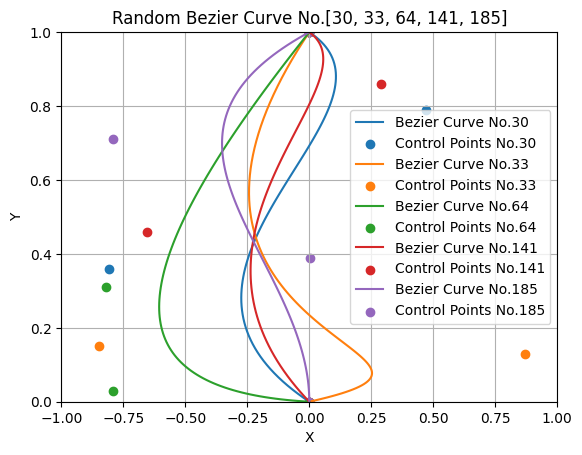

In [6]:
class BeizierCurveCSV:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        self.df = pd.read_csv(csv_path)
        self.cur_num = self.df['ID'].max()

    def curve(self, num):
        curve = self.df[self.df['ID'] == num]
        curve = curve.drop(columns='ID')
        curve = curve.values.tolist()
        return curve
    
    def random_curve(self):
        num = random.randint(1, self.cur_num)
        curve = self.df[self.df['ID'] == num]
        curve = curve.drop(columns='ID')
        curve = curve.values.tolist()
        return curve, num
    
    def multi_curve(self, list_num):
        multi_curve = []
        for num in list_num:
            curve = self.df[self.df['ID'] == num]
            curve = curve.drop(columns='ID')
            curve = curve.values.tolist()
            multi_curve.append(curve)
        return multi_curve

    def random_multi_curve(self, n):
        list_num = []
        for _ in range(n):
            list_num.append(random.randint(1, self.cur_num))
        return self.multi_curve(list_num), list_num

    def all_curve(self):
        all_curve = []
        for num in range(1, self.cur_num + 1):
            curve = self.df[self.df['ID'] == num]
            curve = curve.drop(columns='ID')
            curve = curve.values.tolist()
            all_curve.append(curve)
        return all_curve
    
    def parameterize_curve(self, num):
        curve = self.curve(num)
        control_points = []
        for point in curve:
            control_points.append((point[0], point[1]))
        
        print("Random Bezier Curve No." + str(num) + " Control Points (excluding start and end points):")
        for point in control_points[1:-1]:
            print(f"({point[0]}, {point[1]})")

        # Parameterize the bezier curve
        t = np.linspace(0, 1, 100)
        bezier_curve = np.array([(1 - t) ** 3 * control_points[0][0] + 3 * t * (1 - t) ** 2 * control_points[1][0]
                                    + 3 * t ** 2 * (1 - t) * control_points[2][0] + t ** 3 * control_points[3][0],
                                    (1 - t) ** 3 * control_points[0][1] + 3 * t * (1 - t) ** 2 * control_points[1][1]
                                    + 3 * t ** 2 * (1 - t) * control_points[2][1] + t ** 3 * control_points[3][1]])
        return bezier_curve
            
    
    def plot1(self, num):
        curve = self.parameterize_curve(num)
        control_points = self.curve(num)
        plt.plot(curve[0], curve[1], label='Bezier Curve')
        plt.scatter(*zip(*control_points), color='red', label='Control Points')
        plt.xlim(-1, 1)
        plt.ylim(0, 1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Random Bezier Curve No.' + str(num))
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_multi(self, list_num):
        num_list = []
        for num in list_num:
            curve = self.parameterize_curve(num)
            control_points = self.curve(num)
            num_list.append(num)
            plt.plot(curve[0], curve[1], label='Bezier Curve No.' + str(num))
            plt.scatter(*zip(*control_points), label='Control Points No.' + str(num))
        plt.xlim(-1, 1)
        plt.ylim(0, 1)
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Random Bezier Curve No.' + str(list_num) )
        plt.legend()
        plt.grid(True)
        plt.show()
    
    def plot_random_multi(self, n):
        list_num = []
        for _ in range(n):
            list_num.append(random.randint(1, self.cur_num))
        list_num = sorted(list_num)
        self.plot_multi(list_num)


# Test the class
k = BeizierCurveCSV(output_dir / 'bezier_curve.csv')
k.plot1(1)
k.plot_multi([1, 23, 24, 95 ,175])
k.plot_random_multi(5)
        

In [7]:
keep_cols = ['Class', 'Patient Name', 'Genus-Species', 'Part', 'ID', 'Image Path', 'DCM dir', 'Porosity']
df = df[keep_cols]

for i, rows in tqdm(df.iterrows()):
    img = read_png(rows["Image Path"])   
    img_rotated = rotate_image(img, angle=0, crop_ratio=0.5, mirror=True)         
    img_rotated = img_rotated[::2, ::2]
    df.loc[i, '2D Porosity'] = np.count_nonzero(img_rotated==0)/img_rotated.size   

print_dataframe(df, sample=True)

4782it [00:04, 1039.76it/s]


|      | Class   | Patient Name                    | Genus-Species                                | Part    |   ID | Image Path                                                                                                 | DCM dir                                                                                                                |   Porosity |   2D Porosity |
|-----:|:--------|:--------------------------------|:---------------------------------------------|:--------|-----:|:-----------------------------------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------|-----------:|--------------:|
| 2444 | Mammala | Antilope_cervicapra_tibia       | Antilope_cervicapra-blackbuck                | tibia   |   15 | c:\Users\User\Desktop\SWCLab\img_src_all\M_Antilope_cervicapra_tibia_ID[015]_s[45]_x[-10]_y[-30].png       | c:\Users\User\Desktop\

In [8]:
def get_sample_df(df, groupby_Genus = 'Casuarius_casuarius-southern_cassowary',  groupby_Part='femur', groupby_id= "22"):
    # df_group = df.groupby(groupby_col)
    # df_sample = df_group.agg(lambda x: x.sample(min(n_samples, len(x)), random_state=1)).reset_index()
    df_sample = df[(df['2D Porosity'] > 0.48) & (df['2D Porosity'] < 0.5)]
    df_sample = df_sample[(df_sample['Genus-Species'] == groupby_Genus) & (df_sample['Part'] == groupby_Part) & (df_sample['ID'] == groupby_id)]
    for i, rows in df_sample.iterrows():
        img = read_png(rows["Image Path"])   
        img_rotated = rotate_image(img, angle=0, crop_ratio=0.5, mirror=True)        
        img_rotated = img_rotated[::2, ::2]
    return df_sample

df_sample = get_sample_df(df)
keep_cols = ['Class', 'Patient Name', 'Genus-Species', 'Part', 'ID', 'Image Path', 'DCM dir', 'Porosity', '2D Porosity']
df_sample = df_sample[keep_cols]
print_dataframe(df_sample)

|     | Class   | Patient Name    | Genus-Species                          | Part   |   ID | Image Path                                                       | DCM dir                                                                                 |   Porosity |   2D Porosity |
|----:|:--------|:----------------|:---------------------------------------|:-------|-----:|:-----------------------------------------------------------------|:----------------------------------------------------------------------------------------|-----------:|--------------:|
| 585 | Aves    | CASUARIUS_FEMUR | Casuarius_casuarius-southern_cassowary | femur  |   22 | ..\img_src_all\A_CASUARIUS_FEMUR_ID[022]_s[55]_x[-40]_y[-30].png | ..\dcm_src\Aves\Casuariiformes\Casuariidae\Casuarius_casuarius-southern_cassowary\femur |      0.517 |         0.488 |
----------------------------------------------------------------------------------------------------


In [9]:
def save_as_dcm(refer_dcm_file, image, pixel_spacing, num, pos, thickness, output_path):
    image2d = image.astype(np.float16)

    meta = pydicom.Dataset()
    meta.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.MRImageStorage
    meta.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian  

    ds = pydicom.dcmread(refer_dcm_file)

    ds.Rows = image2d.shape[0]
    ds.Columns = image2d.shape[1]

    ds.PixelData = image2d.tobytes()

    ds.PixelSpacing = "{}\\{}".format(pixel_spacing, pixel_spacing)
    ds.SliceThickness = thickness

    ds.InstanceNumber = num
    ds.ImagePositionPatient = [0, pos, pos]    

    ds.save_as(output_path) 

In [11]:
#this is the setup of 10*10*10 unit cube
margin_range = 2
# pixel_spacing = 0.35
image_size = 106
pixel_spacing = 10/(image_size-margin_range*2)
print(f"pixel spacing: {pixel_spacing}")
n_slices = 101

start_pos = pixel_spacing
end_pos = pixel_spacing*image_size-(margin_range*2)*pixel_spacing+pixel_spacing*2

all_pos = np.linspace(start_pos, end_pos, n_slices)
thickness = (end_pos-start_pos)/(n_slices)
all_pos = np.append(0, all_pos)
all_pos = np.append(all_pos, end_pos+thickness)

print(f"start position: {start_pos}")

pixel spacing: 0.09803921568627451
start position: 0.09803921568627451


1 )  [[0.0, 0.0], [-0.419, 0.25], [0.598, 0.29], [0.0, 1.0]]
2 )  [[0.0, 0.0], [-0.569, 0.26], [0.735, 0.57], [0.0, 1.0]]
3 )  [[0.0, 0.0], [0.84, 0.0], [0.854, 0.37], [0.0, 1.0]]
4 )  [[0.0, 0.0], [-0.306, 0.2], [0.792, 0.67], [0.0, 1.0]]
5 )  [[0.0, 0.0], [0.17, 0.44], [-0.014, 0.58], [0.0, 1.0]]
6 )  [[0.0, 0.0], [0.318, 0.5], [-0.988, 0.62], [0.0, 1.0]]
7 )  [[0.0, 0.0], [-0.855, 0.46], [0.785, 0.61], [0.0, 1.0]]
8 )  [[0.0, 0.0], [0.964, 0.44], [-0.528, 0.52], [0.0, 1.0]]
9 )  [[0.0, 0.0], [0.204, 0.09], [0.071, 0.65], [0.0, 1.0]]
10 )  [[0.0, 0.0], [0.448, 0.02], [-0.783, 0.09], [0.0, 1.0]]
11 )  [[0.0, 0.0], [0.394, 0.09], [-0.676, 0.34], [0.0, 1.0]]
12 )  [[0.0, 0.0], [0.273, 0.27], [-0.447, 0.36], [0.0, 1.0]]
13 )  [[0.0, 0.0], [0.48, 0.26], [-0.561, 0.64], [0.0, 1.0]]
14 )  [[0.0, 0.0], [-0.179, 0.09], [0.933, 0.36], [0.0, 1.0]]
15 )  [[0.0, 0.0], [-0.664, 0.38], [0.742, 0.43], [0.0, 1.0]]
16 )  [[0.0, 0.0], [-0.054, 0.2], [-0.418, 0.5], [0.0, 1.0]]
17 )  [[0.0, 0.0], [-0.122

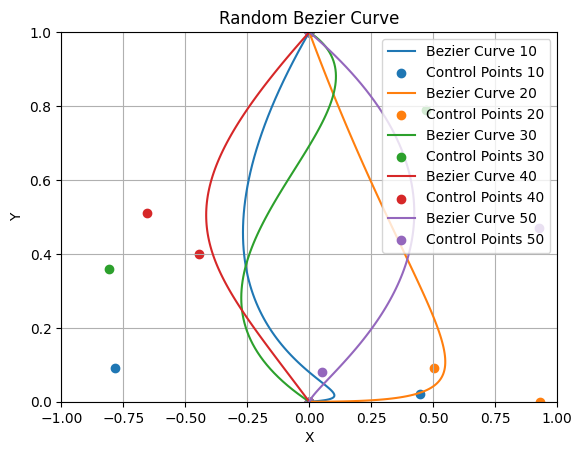

In [15]:
BasC = BeizierCurveCSV(output_dir / 'bezier_curve.csv')
curves,num_list= BasC.all_curve(), list(range(1, BasC.cur_num + 1))
BCurves = []
for curve, num in zip(curves, num_list):
    BCurve = BezierCurve(n=4, control_points=curve, id=num)
    # print(BCurve.control_points)
    # print()
    BCurves.append(BCurve)

for BCurve in BCurves:
    # BCurve.plot()
    print(BCurve.id,') ',BCurve.control_points)

for BCurve in BCurves:
    if BCurve.id in [10, 20, 30, 40, 50]:
        BCurve.plot()



In [16]:

# gererate dcm files for each slice of the image shifted by the bezier curve no need to rotate the image
for i, rows in df_sample.iterrows():
    num = 1

    # refer_dcm_file = [os.path.join(rows["DCM dir"], f) for f in os.listdir(rows["DCM dir"]) if re.search(f".+Im{rows['ID'].zfill(3)}.+", f)][0]
    # img = read_png(rows["Image Path"])   

    for BCurve in BCurves:
        refer_dcm_file = [os.path.join(rows["DCM dir"], f) for f in os.listdir(rows["DCM dir"]) if re.search(f".+Im{rows['ID'].zfill(3)}.+", f)][0]
        img = read_png(rows["Image Path"])
        pts = BCurve.slice(n_slices)
        curve_output_path = output_dir / f'{Path(rows["Image Path"]).stem}_Curve[{BCurve.id}]'
        os.makedirs(curve_output_path, exist_ok=True)
        for j, pos,pt in zip(range(n_slices), all_pos, pts):
            img_shifted = image_x_shift(img, shift_ratio=pt)
            # img_shifted = img_shifted[::2, ::2]
            img_shifted = add_margin(img_shifted, margin_range)

            if j == 0 or j == n_slices-1:
                img_shifted = np.zeros_like(img_shifted)
            dcm_output_path = curve_output_path / f'{Path(rows["Image Path"]).stem}_z[{pos:.2f}]_Curve[{BCurve.id}].dcm'
            save_as_dcm(refer_dcm_file, img_shifted, pixel_spacing, num, pos, thickness, dcm_output_path)
            num += 1


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\pydicom\valuerep.py:290: UserWarning: The value length (19) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [17]:
output_dir_stl = work_dir / 'mesh_stl_model'
os.makedirs(output_dir_stl, exist_ok=True)
output_dir_off = work_dir / 'mesh_off_model'
os.makedirs(output_dir_off, exist_ok=True)

In [18]:
def dcm_to_3d(dcm_dir, output_path):
    reader = vtk.vtkDICOMImageReader()
    reader.SetDirectoryName(dcm_dir)
    reader.Update()

    ConstPixelSpacing = reader.GetPixelSpacing()

    threshold = vtk.vtkImageThreshold()
    threshold.SetInputConnection(reader.GetOutputPort())
    threshold.ThresholdByLower(50)
    threshold.ReplaceInOn()
    threshold.SetInValue(0) 
    threshold.ReplaceOutOn()
    threshold.SetOutValue(1) 
    threshold.Update()

    dmc = vtk.vtkDiscreteMarchingCubes()
    dmc.SetInputConnection(threshold.GetOutputPort())
    dmc.GenerateValues(1, 1, 1)
    dmc.Update()

    smoother = vtk.vtkSmoothPolyDataFilter()
    smoother.SetInputConnection(dmc.GetOutputPort())
    smoother.SetNumberOfIterations(30)
    smoother.SetRelaxationFactor(0.1)
    smoother.BoundarySmoothingOn()
    smoother.Update()

    if os.path.exists(output_path):
        os.remove(output_path)

    writer = vtk.vtkSTLWriter()
    writer.SetInputConnection(smoother.GetOutputPort())
    # writer.SetFileTypeToBinary()
    writer.SetFileName(output_path)
    writer.Write()

    #clear
    del reader, threshold, dmc, smoother, writer
    vtk.vtkObject.GlobalWarningDisplayOff()

In [19]:
def STLtoOFF(import_path, output_path):
    up_conversion = None
    result = mt.convert(import_path, output_path, up_conversion)
    with open(output_path, 'w') as f:
        f.write(result)
    #clear
    del up_conversion, result

In [20]:
for i, dir in tqdm(enumerate(os.listdir(output_dir))):
    if os.path.isdir(os.path.join(output_dir, dir)):
        output_path_stl = os.path.join(output_dir_stl, dir + '.stl')
        output_path_off = os.path.join(output_dir_off, dir + '.off')
        dcm_to_3d(os.path.join(output_dir, dir), output_path_stl)
        STLtoOFF(output_path_stl, output_path_off)

0it [00:00, ?it/s]

In [22]:
df_sample.to_pickle(work_dir / f'result_df.csv')